In [ ]:
!pip install opencv-python-headless numpy matplotlib scikit-image scikit-learn tensorflow

Number of training images: 1027
Number of testing images: 256
Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 284s 14s/step - accuracy: 0.8856 - loss: 0.1919 - val_accuracy: 0.6133 - val_loss: 6.4940
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 226s 12s/step - accuracy: 0.9734 - loss: 0.0816 - val_accuracy: 0.5000 - val_loss: 52.2723
Training Accuracy: 97.96%
Testing  Accuracy: 50.00%


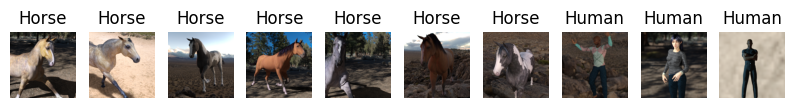

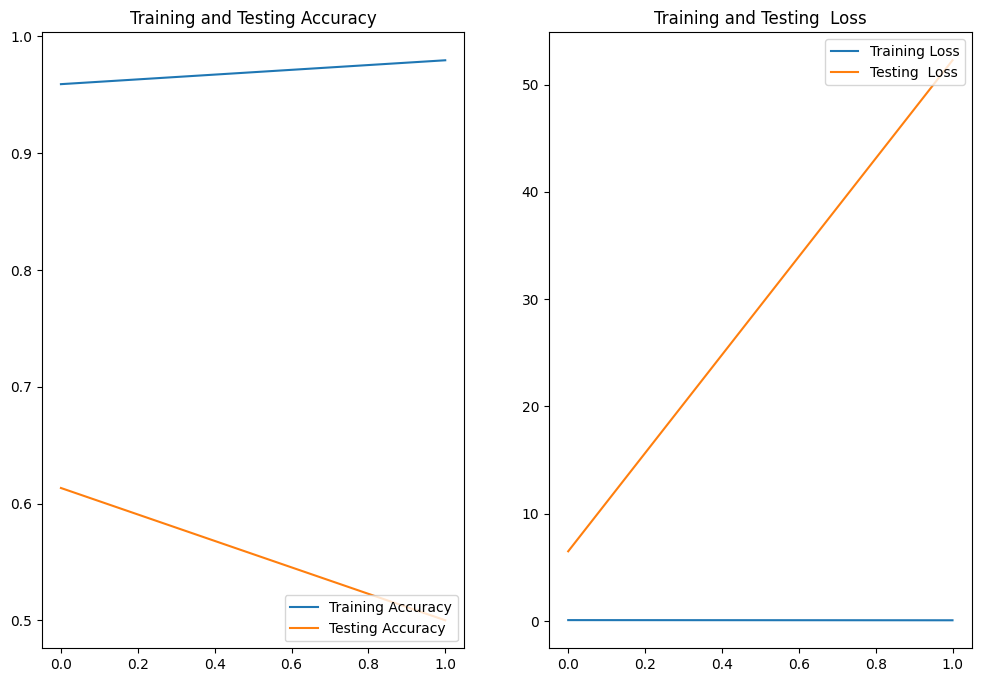

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

train_ds, test_ds = tfds.load('horses_or_humans', split=['train', 'test'], as_supervised=True)

num_train = tf.data.experimental.cardinality(train_ds).numpy()
num_test = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Number of training images: {num_train}")
print(f"Number of testing images: {num_test}")

def plot_samples(dataset, num_samples=10):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title("Human" if label == 1 else "Horse")
        plt.axis("off")

plot_samples(train_ds)

def augment(image, label):
    image = tf.image.resize(image, (224, 224)) 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.rot90(image)
    return image, label

augmented_train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, (224, 224)), label), 
                      num_parallel_calls=tf.data.AUTOTUNE)


def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0 
    return image, label

augmented_train_ds = augmented_train_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 64
augmented_train_ds = augmented_train_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights="imagenet")
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs = 2
history = model.fit(augmented_train_ds, validation_data=test_ds, epochs=epochs)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Testing  Accuracy: {val_acc * 100:.2f}%")

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Testing Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Testing Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Testing  Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Testing  Loss')
    plt.show()

plot_history(history)
